In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]="0"; 

In [2]:
import ktrain
from ktrain import text

Using TensorFlow backend.


using Keras version: 2.2.4


# Building a Chinese-Language Sentiment Analyzer

In this notebook, we will build a Chinese-language text classification model in 4 simple steps. More specifically, we will build a model that classifies Chinese hotel reviews as either positive or negative.

The dataset can be downloaded from Chengwei Zhang's GitHub repository [here](https://github.com/Tony607/Chinese_sentiment_analysis/tree/master/data/ChnSentiCorp_htl_ba_6000).

(**Disclaimer:** I don't speak Chinese. Please forgive mistakes.)  

## STEP 1:  Load and Preprocess the Data

First, we use the `texts_from_folder` function to load and preprocess the data.  We assume that the data is in the following form:
```
    ├── datadir
    │   ├── train
    │   │   ├── class0       # folder containing documents of class 0
    │   │   ├── class1       # folder containing documents of class 1
    │   │   ├── class2       # folder containing documents of class 2
    │   │   └── classN       # folder containing documents of class N
```
We set `val_pct` as 0.1, which will automatically sample 10% of the data for validation.  Since we will be using a pretrained BERT model for classification, we specifiy `preprocess_mode='bert'`.  If you are using any other model (e.g., `fasttext`), you should either omit this parameter or use `preprocess_mode='standard'`).

**Notice that there is nothing speical or extra we need to do here for non-English text.**  *ktrain* automatically detects the language and character encoding and prepares the data and configures the model appropriately.



In [3]:
(x_train, y_train), (x_test, y_test), preproc = text.texts_from_folder('data/ChnSentiCorp_htl_ba_6000', 
                                                                       maxlen=75, 
                                                                       max_features=30000,
                                                                       preprocess_mode='standard',
                                                                       train_test_names=['train'],
                                                                       val_pct=0.1,
                                                                       classes=['pos', 'neg'])

detected encoding: GB18030
Decoding with GB18030 failed 1st attempt - using GB18030 with skips
skipped 112 lines (0.3%) due to character decoding errors
skipped 6 lines (0.2%) due to character decoding errors


Building prefix dict from the default dictionary ...
I0930 12:27:49.133197 140175850424128 __init__.py:111] Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
I0930 12:27:49.135240 140175850424128 __init__.py:131] Loading model from cache /tmp/jieba.cache
Loading model cost 0.650 seconds.


language: zh-cn


I0930 12:27:49.785069 140175850424128 __init__.py:163] Loading model cost 0.650 seconds.
Prefix dict has been built succesfully.
I0930 12:27:49.787230 140175850424128 __init__.py:164] Prefix dict has been built succesfully.


Word Counts: 22193
Nrows: 5324
5324 train sequences
Average train sequence length: 81
x_train shape: (5324,75)
y_train shape: (5324,2)
592 test sequences
Average test sequence length: 84
x_test shape: (592,75)
y_test shape: (592,2)


## STEP 2:  Create a Model and Wrap in Learner Object

In [4]:
model = text.text_classifier('fasttext', (x_train, y_train) , preproc=preproc)
learner = ktrain.get_learner(model, 
                             train_data=(x_train, y_train), 
                             val_data=(x_test, y_test), 
                             batch_size=32)

Is Multi-Label? False
compiling word ID features...
maxlen is 75
done.


## STEP 3: Estimate the LR
We'll use the *ktrain* learning rate finder to find a good learning rate to use with *fasttext*.


simulating training for different learning rates... this may take a few moments...
Epoch 1/1024
5324/5324 [==============================] - 2s 455us/step - loss: 1.0073 - acc: 0.4981
Epoch 2/1024
5324/5324 [==============================] - 2s 312us/step - loss: 1.0082 - acc: 0.5004
Epoch 3/1024
5324/5324 [==============================] - 2s 312us/step - loss: 1.0107 - acc: 0.4970
Epoch 4/1024
5324/5324 [==============================] - 2s 303us/step - loss: 1.0079 - acc: 0.4880
Epoch 5/1024
5324/5324 [==============================] - 2s 321us/step - loss: 0.8720 - acc: 0.5441
Epoch 6/1024
5324/5324 [==============================] - 2s 303us/step - loss: 0.6938 - acc: 0.6349
Epoch 7/1024
5324/5324 [==============================] - 2s 311us/step - loss: 0.5119 - acc: 0.7601
Epoch 8/1024
5324/5324 [==============================] - 2s 306us/step - loss: 0.4868 - acc: 0.7842
Epoch 9/1024
5324/5324 [==============================] - 2s 308us/step - loss: 0.6517 - acc: 0.6206
Epoch 10

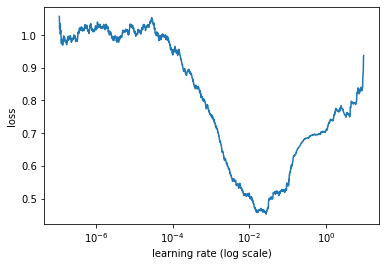

In [5]:
learner.lr_find(show_plot=True)

## STEP 3: Train the Model

We will use the `autofit` method that employs a triangular learning rate policy for 10 epochs (i.e., roughly 20 seconds) and then select the weights from the epoch with the best validation performance.

In [5]:
learner.autofit(5e-3, 10, checkpoint_folder='/tmp/saved_weights')



begin training using triangular learning rate policy with max lr of 0.005...
Train on 5324 samples, validate on 592 samples
Epoch 1/10
5324/5324 [==============================] - 2s 469us/step - loss: 0.7082 - acc: 0.6245 - val_loss: 0.4294 - val_acc: 0.8176
Epoch 2/10
5324/5324 [==============================] - 2s 351us/step - loss: 0.4680 - acc: 0.7840 - val_loss: 0.3725 - val_acc: 0.8497
Epoch 3/10
5324/5324 [==============================] - 2s 360us/step - loss: 0.3695 - acc: 0.8411 - val_loss: 0.3284 - val_acc: 0.8632
Epoch 4/10
5324/5324 [==============================] - 2s 352us/step - loss: 0.3063 - acc: 0.8715 - val_loss: 0.3000 - val_acc: 0.8885
Epoch 5/10
5324/5324 [==============================] - 2s 362us/step - loss: 0.2699 - acc: 0.8929 - val_loss: 0.2750 - val_acc: 0.9003
Epoch 6/10
5324/5324 [==============================] - 2s 353us/step - loss: 0.2214 - acc: 0.9113 - val_loss: 0.2885 - val_acc: 0.9054
Epoch 7/10
5324/5324 [==============================] - 2s

Looks like Epoch # 9 is the best (`val_acc=90.54%`).  Let's select that one.

In [6]:
learner.model.load_weights('/tmp/saved_weights/weights-09.hdf5')

In [7]:
learner.validate(class_names=preproc.get_classes())

              precision    recall  f1-score   support

         neg       0.90      0.92      0.91       304
         pos       0.91      0.89      0.90       288

    accuracy                           0.91       592
   macro avg       0.91      0.91      0.91       592
weighted avg       0.91      0.91      0.91       592



array([[279,  25],
       [ 31, 257]])

### Inspecting the Misclassifications

In [8]:
learner.view_top_losses(n=1, preproc=preproc)

----------
id:40 | loss:6.52 | true:pos | pred:neg)

这里 的 早餐 是 我 看到 的 最差 的 一个 基本上 没什么 吃 的 就 看到 服务员 在 不 听 的 加 白粥 下次 在 来 我 是 不会 住 在 这里 的


Using Google Translate, the above roughly translates to:
```
The breakfast here is the worst one I have ever seen. Basically, I have nothing to eat. I can see that the waiter is not listening to the white porridge. I will not live here next time.
```

Mistranslations aside, this is clearly a negative review.  It is incorrectly labeled as positive.

### Making Predictions on New Data

In [9]:
p = ktrain.get_predictor(learner.model, preproc)

Predicting label for the text
> "*I despise the service of this hotel.*"

In [10]:
p.predict("我鄙视这家酒店的服务。")

'neg'

Predicting label for:
> "*I like the service of this hotel.*"

In [11]:
p.predict('我喜欢这家酒店的服务')

'pos'